# CS 171 Final Project — Data Preparation Progress Update
### Waste Sorting with Classical ML + CNNs
**Authors:** Lwin Moe  
**Update Date:** Dec 4, 2025

This notebook shows the data preparation process, focusing on the TACO dataset (waste images "in the wild"). The goal is to create a clean classification dataset **mapped to TrashNet 6 classes**: Cardboard, Glass, Metal, Paper, Plastic, and Trash.


## Project Goal (Short Summary)
Our project explores how well supervised learning models can classify common waste types.  
We compare:

- Classical ML (KNN, Logistic Regression, Decision Trees)
- Convolutional Neural Networks (CNNs)
- Ensemble majority voting

In this update, we show our **data preparation work**, focusing on:
- loading TACO annotations  
- mapping TACO categories to 6 TrashNet classes  
- inspecting images  
- preprocessing to 200×200 and creating stratified train/val/test splits  


## 1. Project Setup
- Create folders for TrashNet and TACO datasets
- Confirm dataset structure
- Load image paths
- Preview dataset statistics

In [9]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Path where you downloaded TACO
TACO_ROOT = "./data/TACO/data"   # <-- change if needed
ANNOTATION_FILE = os.path.join(TACO_ROOT, "annotations.json")

## Load TACO annotation json

In [10]:
with open(ANNOTATION_FILE, 'r') as f:
    data = json.load(f)

categories = data["categories"]
annotations = data["annotations"]
images = data["images"]

print("Total Images:", len(images))
print("Total Annotations:", len(annotations))
print("Total Categories:", len(categories))


Total Images: 1500
Total Annotations: 4784
Total Categories: 60


In [11]:
for c in categories:
    print(c["id"], c["name"])


0 Aluminium foil
1 Battery
2 Aluminium blister pack
3 Carded blister pack
4 Other plastic bottle
5 Clear plastic bottle
6 Glass bottle
7 Plastic bottle cap
8 Metal bottle cap
9 Broken glass
10 Food Can
11 Aerosol
12 Drink can
13 Toilet tube
14 Other carton
15 Egg carton
16 Drink carton
17 Corrugated carton
18 Meal carton
19 Pizza box
20 Paper cup
21 Disposable plastic cup
22 Foam cup
23 Glass cup
24 Other plastic cup
25 Food waste
26 Glass jar
27 Plastic lid
28 Metal lid
29 Other plastic
30 Magazine paper
31 Tissues
32 Wrapping paper
33 Normal paper
34 Paper bag
35 Plastified paper bag
36 Plastic film
37 Six pack rings
38 Garbage bag
39 Other plastic wrapper
40 Single-use carrier bag
41 Polypropylene bag
42 Crisp packet
43 Spread tub
44 Tupperware
45 Disposable food container
46 Foam food container
47 Other plastic container
48 Plastic glooves
49 Plastic utensils
50 Pop tab
51 Rope & strings
52 Scrap metal
53 Shoe
54 Squeezable tube
55 Plastic straw
56 Paper straw
57 Styrofoam piece
58

In [12]:
cat_id_to_name = {c['id']: c['name'] for c in categories}

## Extracting all images from selected categories

In [13]:
from collections import defaultdict

image_to_categories = defaultdict(list)

for ann in annotations:
    image_to_categories[ann['image_id']].append(cat_id_to_name[ann['category_id']])

## Previewing a few samples

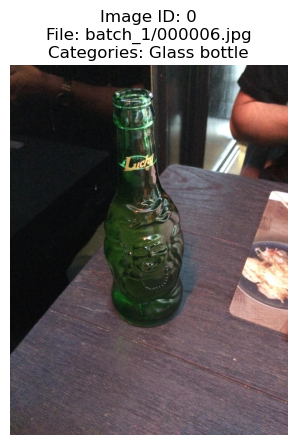

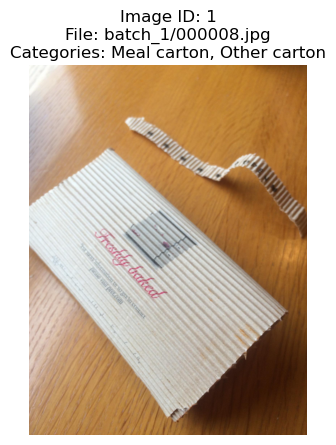

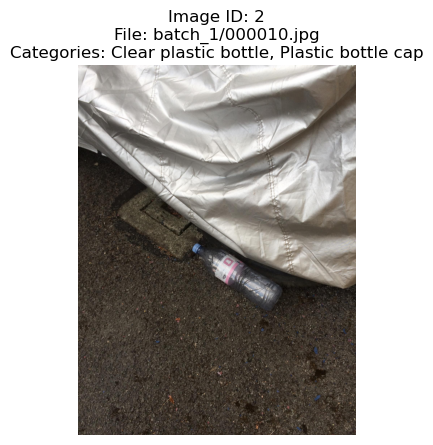

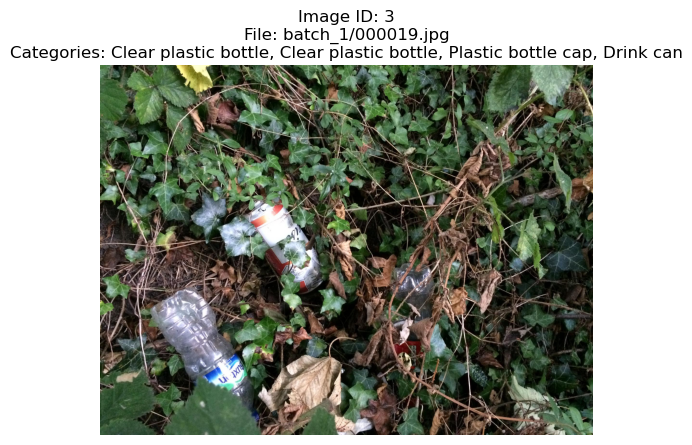

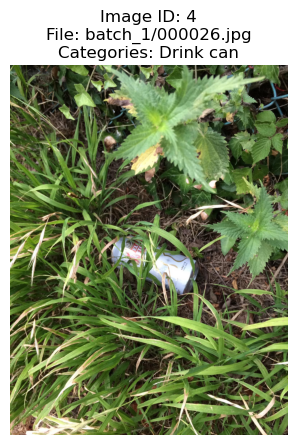

In [14]:
sample_ids = list(image_to_categories.keys())[:5]

for img_id in sample_ids:
    # Get image info
    img_info = next(i for i in images if i["id"] == img_id)
    img_path = os.path.join(TACO_ROOT, img_info["file_name"])

    # Make sure file exists
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        continue

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image ID: {img_id}\n"
              f"File: {img_info['file_name']}\n"
              f"Categories: {', '.join(image_to_categories[img_id])}")
    plt.show()


This looks good. Now let's map TACO categories to 6 TrashNet classes.

## 1. Mapping TACO Categories to TrashNet Classes

Goal: Map all TACO categories to 6 main waste types for simplified classification
- **Cardboard**: Paper boxes, corrugated cartons, etc.
- **Glass**: Glass bottles, jars, cups, broken glass
- **Metal**: Cans, metal lids, scrap metal, aluminum
- **Paper**: Paper bags, magazines, normal paper
- **Plastic**: Plastic bottles, containers, wrappers, bags
- **Trash**: Non-recyclable garbage, food waste, textiles, etc.


In [15]:
TRASHNET_CLASSES = ["Cardboard", "Glass", "Metal", "Paper", "Plastic", "Trash"]

# Mapping from TACO categories to TrashNet classes
TACO_TO_TRASHNET = {
    # Cardboard
    "Corrugated carton": "Cardboard",
    "Other carton": "Cardboard",
    "Pizza box": "Cardboard",
    "Meal carton": "Cardboard",
    "Egg carton": "Cardboard",
    
    # Glass
    "Glass bottle": "Glass",
    "Glass jar": "Glass",
    "Glass cup": "Glass",
    "Broken glass": "Glass",
    
    # Metal
    "Drink can": "Metal",
    "Food Can": "Metal",
    "Metal bottle cap": "Metal",
    "Metal lid": "Metal",
    "Scrap metal": "Metal",
    "Aluminium foil": "Metal",
    "Aluminium blister pack": "Metal",
    "Pop tab": "Metal",
    
    # Paper
    "Magazine paper": "Paper",
    "Normal paper": "Paper",
    "Paper bag": "Paper",
    "Paper cup": "Paper",
    "Paper straw": "Paper",
    "Wrapping paper": "Paper",
    "Tissues": "Paper",
    "Toilet tube": "Paper",
    
    # Plastic
    "Clear plastic bottle": "Plastic",
    "Other plastic bottle": "Plastic",
    "Plastic bottle cap": "Plastic",
    "Plastic lid": "Plastic",
    "Plastic film": "Plastic",
    "Disposable plastic cup": "Plastic",
    "Other plastic cup": "Plastic",
    "Other plastic container": "Plastic",
    "Plastic utensils": "Plastic",
    "Crisp packet": "Plastic",
    "Other plastic wrapper": "Plastic",
    "Disposable food container": "Disposable food container",
    "Polypropylene bag": "Plastic",
    "Single-use carrier bag": "Plastic",
    "Plastic glooves": "Plastic",
    "Plastic straw": "Plastic",
    "Spread tub": "Plastic",
    "Squeezable tube": "Plastic",
    "Tupperware": "Plastic",
    "Carded blister pack": "Plastic",
    
    # Trash (non-recyclable)
    "Aerosol": "Trash",
    "Battery": "Trash",
    "Cigarette": "Trash",
    "Food waste": "Trash",
    "Garbage bag": "Trash",
    "Styrofoam piece": "Trash",
    "Foam cup": "Trash",
    "Foam food container": "Trash",
    "Shoe": "Trash",
    "Rope & strings": "Trash",
    "Six pack rings": "Trash",
    "Unlabeled litter": "Trash",
    "Drink carton": "Trash",
}

# Create output directories
BASE_DIR = "TACO_clean"
for cls in TRASHNET_CLASSES:
    path = os.path.join(BASE_DIR, cls)
    os.makedirs(path, exist_ok=True)

print("TrashNet class folders created!")
print(f"Classes: {TRASHNET_CLASSES}")


TrashNet class folders created!
Classes: ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']


## 2. Copy & Resize Images (200×200)

- Take raw TACO images

- Map them to our classes

- Resize all images to 200×200

- Save images into the proper class folders

This ensures all images have the same size before training CNNs.

In [17]:
BASE_DIR = "TACO_clean"
SOURCE_DIR = TACO_ROOT

image_to_categories = defaultdict(list)
for ann in annotations:
    cat_id = ann["category_id"]
    cat_name = next(c["name"] for c in categories if c["id"] == cat_id)
    image_to_categories[ann["image_id"]].append(cat_name)

def process_and_copy(img_path, dest_path):
    """Resize image to 200x200 and save"""
    img = Image.open(img_path).convert("RGB")
    img = img.resize((200, 200))
    img.save(dest_path)

# Process images
unmapped_categories = set()
images_processed = 0
images_skipped = 0

for img_info in images:
    img_id = img_info["id"]
    img_file = img_info["file_name"]
    full_path = os.path.join(SOURCE_DIR, img_file)
    
    # Skip missing files
    if not os.path.exists(full_path):
        images_skipped += 1
        continue
    
    # Get TACO categories for this image
    taco_categories = image_to_categories[img_id]
    
    if not taco_categories:
        images_skipped += 1
        continue
    
    # Map TACO categories to TrashNet classes
    trashnet_labels = set()
    for taco_cat in taco_categories:
        if taco_cat in TACO_TO_TRASHNET:
            trashnet_label = TACO_TO_TRASHNET[taco_cat]
            # Skip "Disposable food container" mapping - put in Trash instead
            if trashnet_label != "Disposable food container":
                trashnet_labels.add(trashnet_label)
            else:
                trashnet_labels.add("Trash")
        else:
            unmapped_categories.add(taco_cat)
    
    # If image has no valid mapped labels, skip it
    if not trashnet_labels:
        images_skipped += 1
        continue
    
    # Copy image to each TrashNet class folder
    for trashnet_label in trashnet_labels:
        dest_path = os.path.join(BASE_DIR, trashnet_label, os.path.basename(img_file))
        try:
            process_and_copy(full_path, dest_path)
            images_processed += 1
        except Exception as e:
            print(f"Error processing {full_path}: {e}")

print(f"\nImages processed: {images_processed}")
print(f"Images skipped: {images_skipped}")
print(f"\nUnmapped TACO categories: {unmapped_categories if unmapped_categories else 'None'}")

# Print class distribution
print("\n" + "="*50)
print("Images per TrashNet class:")
print("="*50)
for cls in TRASHNET_CLASSES:
    folder = os.path.join(BASE_DIR, cls)
    count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"{cls:15s}: {count:4d} images")



Images processed: 2281
Images skipped: 49

Unmapped TACO categories: {'Other plastic'}

Images per TrashNet class:
Cardboard      :  101 images
Glass          :   73 images
Metal          :  136 images
Paper          :  110 images
Plastic        :  199 images
Trash          :  156 images


## 3. Compute Dataset Statistics (Mean & Std)

- Compute the mean and standard deviation of all images in the new dataset.

These values are required for:

- Normalizing images before training a CNN

- Matching common vision ML pipelines

- Ensuring stable model convergence

In [19]:
means = []
stds = []

for cat_name in TRASHNET_CLASSES:
    folder = os.path.join(BASE_DIR, cat_name)
    for img_name in os.listdir(folder):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = np.array(Image.open(os.path.join(folder, img_name))) / 255.0
            means.append(img.mean(axis=(0,1)))
            stds.append(img.std(axis=(0,1)))

dataset_mean = np.mean(means, axis=0)
dataset_std  = np.mean(stds, axis=0)

print("Dataset mean:", dataset_mean)
print("Dataset std:", dataset_std)


Dataset mean: [0.5040377  0.47257524 0.4195698 ]
Dataset std: [0.19105516 0.18089082 0.17627907]


## 4. Creating train/val/test splits

In [20]:
# Creating train/val/test splits
# 70% train, 15% val, 15% test

data = []

for cat_name in TRASHNET_CLASSES:
    folder = os.path.join(BASE_DIR, cat_name)
    if not os.path.exists(folder) or len(os.listdir(folder)) == 0:
        print(f"Skipping empty folder: {folder}")
        continue
    for img_name in os.listdir(folder):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            data.append([os.path.join(folder, img_name), cat_name])

df = pd.DataFrame(data, columns=["filepath", "label"])
print("Images per class before filtering:\n", df['label'].value_counts())

# Identify singleton classes (1 image) and put in train
counts = df['label'].value_counts()
singleton_classes = counts[counts == 1].index.tolist()
singleton_df = df[df['label'].isin(singleton_classes)]
df_rest = df[~df['label'].isin(singleton_classes)]
print("\nSingleton classes:", singleton_classes)

# Stratified split on df_rest (only classes with >=2 images)
if len(df_rest) > 0:
    train_df, temp_df = train_test_split(
        df_rest, test_size=0.3, stratify=df_rest['label'], random_state=42
    )
else:
    train_df = df_rest
    temp_df = pd.DataFrame(columns=df.columns)

# Handle tiny classes in temp_df (classes with <2 images)
if len(temp_df) > 0:
    counts_temp = temp_df['label'].value_counts()
    tiny_classes = counts_temp[counts_temp < 2].index.tolist()
    if tiny_classes:
        print("Tiny classes in temp_df:", tiny_classes)
        tiny_df = temp_df[temp_df['label'].isin(tiny_classes)]
        temp_df = temp_df[~temp_df['label'].isin(tiny_classes)]
    else:
        tiny_df = pd.DataFrame(columns=temp_df.columns)
else:
    tiny_df = pd.DataFrame(columns=df.columns)

# Stratified split for remaining temp_df
if len(temp_df) > 1:
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
    )
else:
    val_df = temp_df
    test_df = pd.DataFrame(columns=df.columns)

# Put singleton and tiny classes into train
train_df = pd.concat([train_df, singleton_df, tiny_df], ignore_index=True)

print("\nTrain/Val/Test sizes:", train_df.shape, val_df.shape, test_df.shape)
print("\nClass distribution in splits:")
print("\nTrain:")
print(train_df['label'].value_counts().to_dict())
print("\nVal:")
print(val_df['label'].value_counts().to_dict())
print("\nTest:")
print(test_df['label'].value_counts().to_dict())

os.makedirs("splits", exist_ok=True)
train_df.to_csv("splits/train.csv", index=False)
val_df.to_csv("splits/val.csv", index=False)
test_df.to_csv("splits/test.csv", index=False)
print("\nCSV files saved to splits/ folder!")


Images per class before filtering:
 label
Plastic      199
Trash        156
Metal        136
Paper        110
Cardboard    101
Glass         73
Name: count, dtype: int64

Singleton classes: []

Train/Val/Test sizes: (542, 2) (116, 2) (117, 2)

Class distribution in splits:

Train:
{'Plastic': 139, 'Trash': 109, 'Metal': 95, 'Paper': 77, 'Cardboard': 71, 'Glass': 51}

Val:
{'Plastic': 30, 'Trash': 23, 'Metal': 20, 'Paper': 17, 'Cardboard': 15, 'Glass': 11}

Test:
{'Plastic': 30, 'Trash': 24, 'Metal': 21, 'Paper': 16, 'Cardboard': 15, 'Glass': 11}

CSV files saved to splits/ folder!


In [21]:
# Crop Objects Using Box

print("="*60)
print("EXTRACTING OBJECT CROPS FROM TACO ANNOTATIONS")
print("="*60)

import json
import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Reload annotations
TACO_ROOT = "./data/TACO/data"
ANNOTATION_FILE = os.path.join(TACO_ROOT, "annotations.json")

with open(ANNOTATION_FILE, 'r') as f:
    data = json.load(f)

categories = data["categories"]
annotations = data["annotations"]
images = data["images"]

# Create mappings
cat_id_to_name = {c['id']: c['name'] for c in categories}
img_id_to_info = {img['id']: img for img in images}

# TACO to TrashNet mapping (same as before)
TACO_TO_TRASHNET = {
    # Cardboard
    "Corrugated carton": "Cardboard",
    "Other carton": "Cardboard",
    "Pizza box": "Cardboard",
    "Meal carton": "Cardboard",
    "Egg carton": "Cardboard",
    
    # Glass
    "Glass bottle": "Glass",
    "Glass jar": "Glass",
    "Glass cup": "Glass",
    "Broken glass": "Glass",
    
    # Metal
    "Drink can": "Metal",
    "Food Can": "Metal",
    "Metal bottle cap": "Metal",
    "Metal lid": "Metal",
    "Scrap metal": "Metal",
    "Aluminium foil": "Metal",
    "Aluminium blister pack": "Metal",
    "Pop tab": "Metal",
    
    # Paper
    "Magazine paper": "Paper",
    "Normal paper": "Paper",
    "Paper bag": "Paper",
    "Paper cup": "Paper",
    "Paper straw": "Paper",
    "Wrapping paper": "Paper",
    "Tissues": "Paper",
    "Toilet tube": "Paper",
    
    # Plastic
    "Clear plastic bottle": "Plastic",
    "Other plastic bottle": "Plastic",
    "Plastic bottle cap": "Plastic",
    "Plastic lid": "Plastic",
    "Plastic film": "Plastic",
    "Disposable plastic cup": "Plastic",
    "Other plastic cup": "Plastic",
    "Other plastic container": "Plastic",
    "Plastic utensils": "Plastic",
    "Crisp packet": "Plastic",
    "Other plastic wrapper": "Plastic",
    "Polypropylene bag": "Plastic",
    "Single-use carrier bag": "Plastic",
    "Plastic glooves": "Plastic",
    "Plastic straw": "Plastic",
    "Spread tub": "Plastic",
    "Squeezable tube": "Plastic",
    "Tupperware": "Plastic",
    "Carded blister pack": "Plastic",
    
    # Trash (non-recyclable)
    "Aerosol": "Trash",
    "Battery": "Trash",
    "Cigarette": "Trash",
    "Food waste": "Trash",
    "Garbage bag": "Trash",
    "Styrofoam piece": "Trash",
    "Foam cup": "Trash",
    "Foam food container": "Trash",
    "Shoe": "Trash",
    "Rope & strings": "Trash",
    "Six pack rings": "Trash",
    "Unlabeled litter": "Trash",
    "Drink carton": "Trash",
    "Disposable food container": "Trash",
}

TRASHNET_CLASSES = ["Cardboard", "Glass", "Metal", "Paper", "Plastic", "Trash"]


CROP_DIR = "TACO_crops"
for cls in TRASHNET_CLASSES:
    os.makedirs(os.path.join(CROP_DIR, cls), exist_ok=True)

print(f"\nProcessing {len(annotations)} annotations...")
print("Extracting object crops using bounding boxes...\n")

crop_count = 0
skipped_count = 0
class_counts = defaultdict(int)

MIN_CROP_SIZE = 32  # Minimum crop size in pixels
TARGET_SIZE = 200   # Resize crops to this size

for ann in annotations:
    try:
        # Get category info
        cat_id = ann['category_id']
        cat_name = cat_id_to_name.get(cat_id)
        
        if cat_name not in TACO_TO_TRASHNET:
            skipped_count += 1
            continue
        
        trashnet_label = TACO_TO_TRASHNET[cat_name]
        
        # Get image info
        img_id = ann['image_id']
        img_info = img_id_to_info.get(img_id)
        if img_info is None:
            skipped_count += 1
            continue
        
        img_path = os.path.join(TACO_ROOT, img_info['file_name'])
        if not os.path.exists(img_path):
            skipped_count += 1
            continue
        
        # Get bounding box [x, y, width, height]
        bbox = ann.get('bbox')
        if bbox is None or len(bbox) != 4:
            skipped_count += 1
            continue
        
        x, y, w, h = bbox
        
        # Skip tiny objects
        if w < MIN_CROP_SIZE or h < MIN_CROP_SIZE:
            skipped_count += 1
            continue
        
        # Open image and crop
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        
        # Add padding around bbox (10% on each side)
        pad_x = w * 0.1
        pad_y = h * 0.1
        
        x1 = max(0, int(x - pad_x))
        y1 = max(0, int(y - pad_y))
        x2 = min(img_w, int(x + w + pad_x))
        y2 = min(img_h, int(y + h + pad_y))
        
        # Crop the object region
        crop = img.crop((x1, y1, x2, y2))
        
        # Resize to target size
        crop = crop.resize((TARGET_SIZE, TARGET_SIZE), Image.LANCZOS)
        
        # Save crop
        ann_id = ann['id']
        crop_filename = f"crop_{img_id}_{ann_id}.jpg"
        crop_path = os.path.join(CROP_DIR, trashnet_label, crop_filename)
        crop.save(crop_path, quality=95)
        
        crop_count += 1
        class_counts[trashnet_label] += 1
        
        if crop_count % 500 == 0:
            print(f"  Processed {crop_count} crops...")
            
    except Exception as e:
        skipped_count += 1
        continue

print(f"\n{'='*60}")
print("CROP EXTRACTION COMPLETE")
print(f"{'='*60}")
print(f"\nTotal crops extracted: {crop_count}")
print(f"Skipped annotations:   {skipped_count}")

print(f"\nCrops per class:")
print("-" * 40)
for cls in TRASHNET_CLASSES:
    print(f"  {cls:12s}: {class_counts[cls]:4d} crops")
print("-" * 40)
print(f"  {'TOTAL':12s}: {sum(class_counts.values()):4d} crops")

EXTRACTING OBJECT CROPS FROM TACO ANNOTATIONS

Processing 4784 annotations...
Extracting object crops using bounding boxes...

  Processed 500 crops...
  Processed 1000 crops...
  Processed 1500 crops...
  Processed 2000 crops...
  Processed 2500 crops...
  Processed 3000 crops...
  Processed 3500 crops...

CROP EXTRACTION COMPLETE

Total crops extracted: 3745
Skipped annotations:   1039

Crops per class:
----------------------------------------
  Cardboard   :  197 crops
  Glass       :  200 crops
  Metal       :  488 crops
  Paper       :  235 crops
  Plastic     : 1650 crops
  Trash       :  975 crops
----------------------------------------
  TOTAL       : 3745 crops


In [24]:
# Train/Test/Split

print("="*60)
print("CREATING SPLITS FROM OBJECT CROPS")
print("="*60)

# Build dataset from crops
data = []
for cls in TRASHNET_CLASSES:
    cls_dir = os.path.join(CROP_DIR, cls)
    if os.path.exists(cls_dir):
        for img_name in os.listdir(cls_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                data.append({
                    'filepath': os.path.join(cls_dir, img_name),
                    'label': cls
                })

df = pd.DataFrame(data)
print(f"\nTotal samples: {len(df)}")
print(f"\nClass distribution:")
print(df['label'].value_counts())

# Stratified split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

print(f"\nSplit sizes:")
print(f"  Train: {len(train_df):4d} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df):4d} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df):4d} samples ({len(test_df)/len(df)*100:.1f}%)")

# Save splits
os.makedirs("splits_crops", exist_ok=True)
train_df.to_csv("splits_crops/train.csv", index=False)
val_df.to_csv("splits_crops/val.csv", index=False)
test_df.to_csv("splits_crops/test.csv", index=False)

print(f"\nSplits saved to splits_crops/ folder!")
print("\nClass distribution in each split:")
print("\nTrain:")
print(train_df['label'].value_counts())
print("\nVal:")
print(val_df['label'].value_counts())
print("\nTest:")
print(test_df['label'].value_counts())

CREATING SPLITS FROM OBJECT CROPS

Total samples: 3745

Class distribution:
label
Plastic      1650
Trash         975
Metal         488
Paper         235
Glass         200
Cardboard     197
Name: count, dtype: int64

Split sizes:
  Train: 2621 samples (70.0%)
  Val:    562 samples (15.0%)
  Test:   562 samples (15.0%)

Splits saved to splits_crops/ folder!

Class distribution in each split:

Train:
label
Plastic      1155
Trash         682
Metal         342
Paper         164
Glass         140
Cardboard     138
Name: count, dtype: int64

Val:
label
Plastic      247
Trash        147
Metal         73
Paper         36
Glass         30
Cardboard     29
Name: count, dtype: int64

Test:
label
Plastic      248
Trash        146
Metal         73
Paper         35
Cardboard     30
Glass         30
Name: count, dtype: int64


SAMPLE CROPPED OBJECTS FROM EACH CLASS


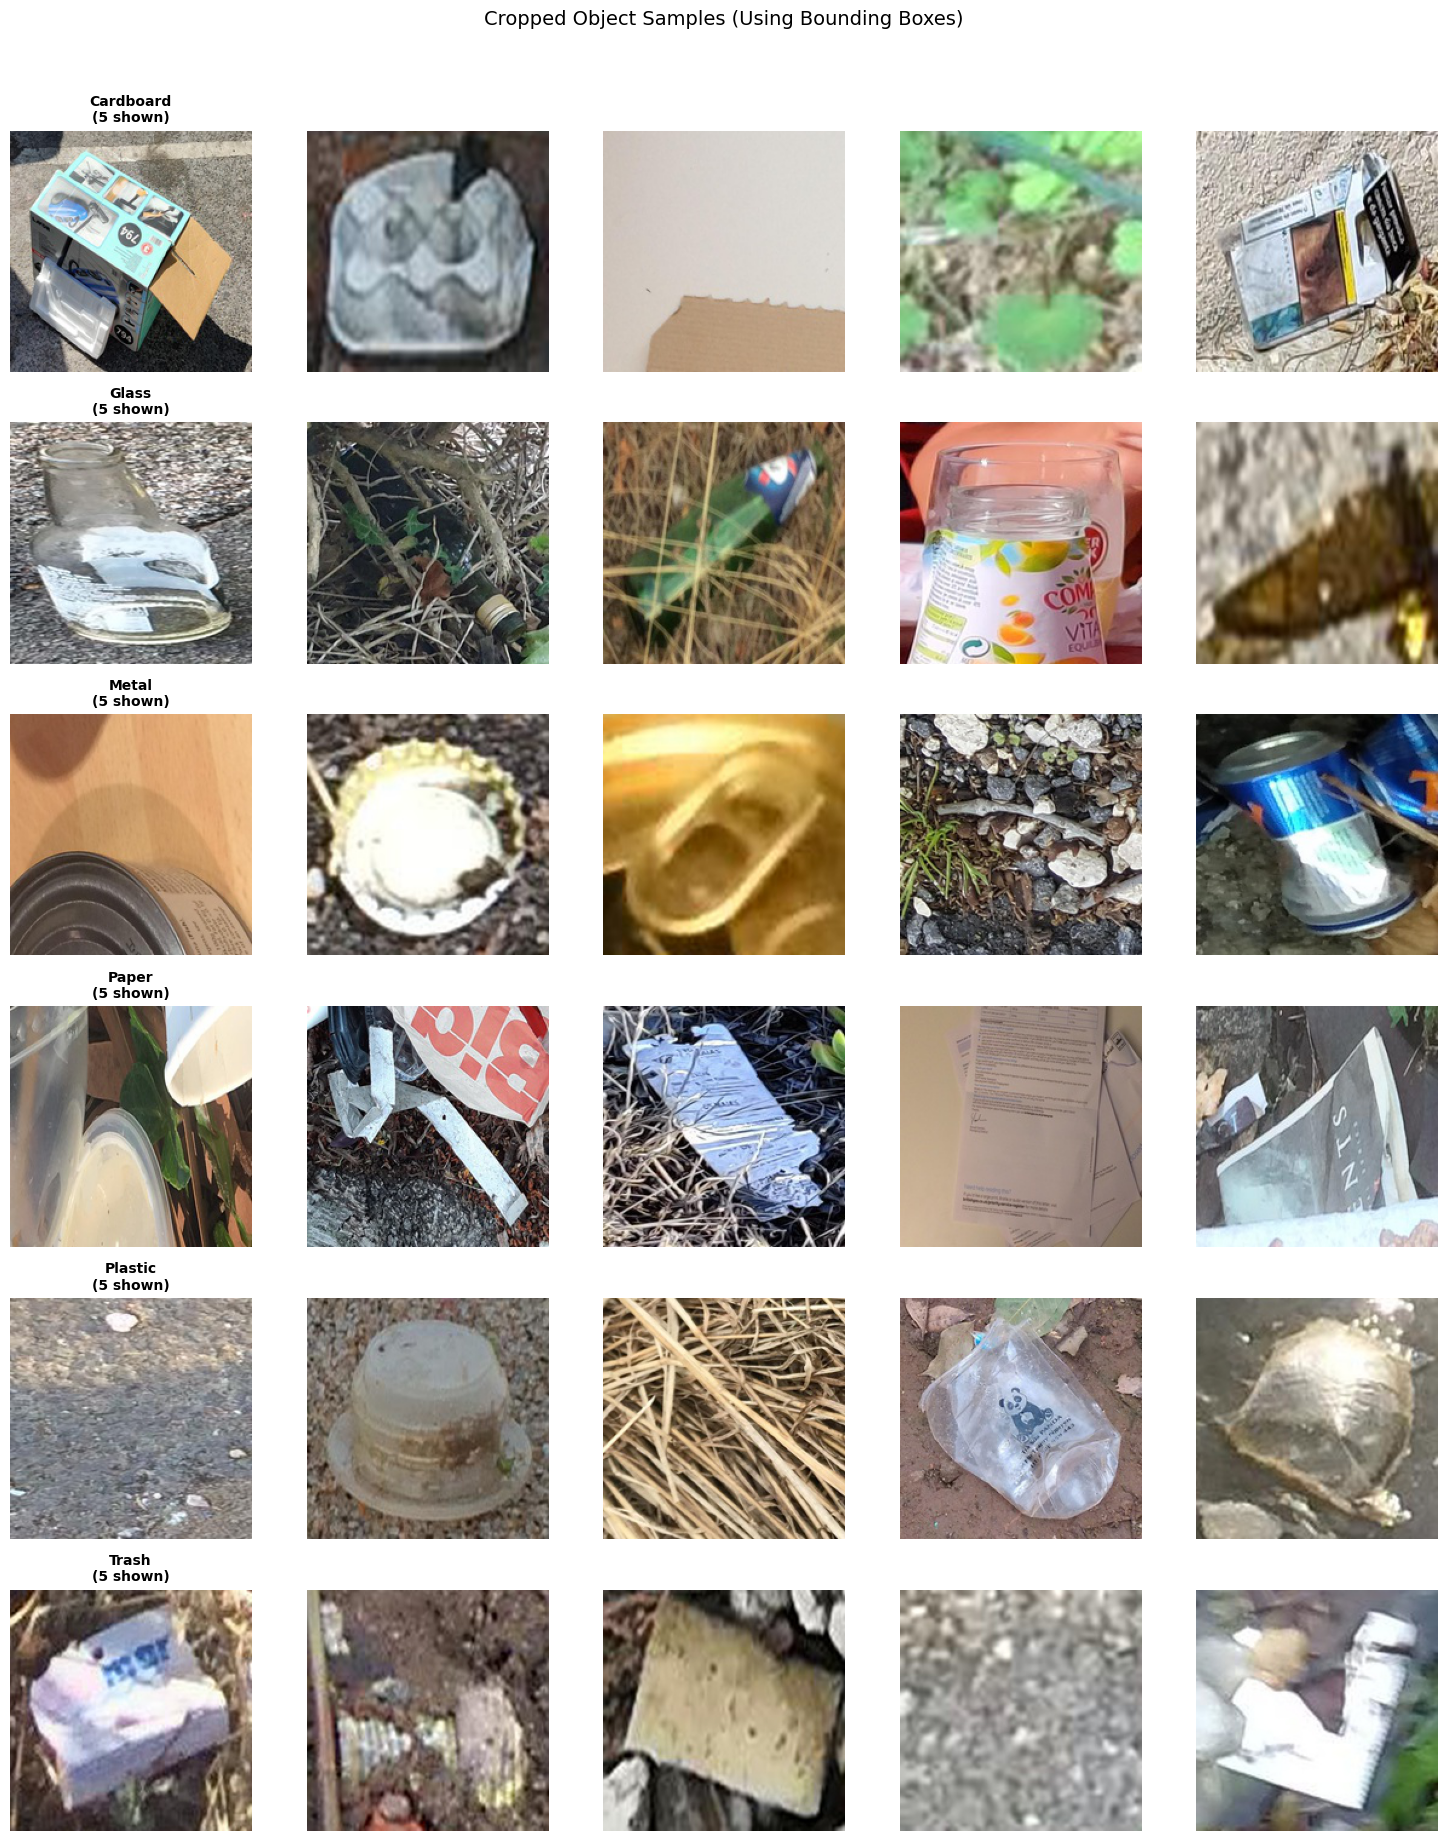


 Object crops are much cleaner than full images!
   Each crop focuses on a single waste object.
   This should significantly improve classification accuracy.


In [25]:
# Looking at the data
import matplotlib.pyplot as plt

print("="*60)
print("SAMPLE CROPPED OBJECTS FROM EACH CLASS")
print("="*60)

fig, axes = plt.subplots(len(TRASHNET_CLASSES), 5, figsize=(15, 3*len(TRASHNET_CLASSES)))

for row, cls in enumerate(TRASHNET_CLASSES):
    cls_dir = os.path.join(CROP_DIR, cls)
    if os.path.exists(cls_dir):
        files = [f for f in os.listdir(cls_dir) if f.endswith('.jpg')][:5]
        for col, fname in enumerate(files):
            img = Image.open(os.path.join(cls_dir, fname))
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_title(f"{cls}\n({len(files)} shown)", fontsize=10, fontweight='bold')
        # Fill empty columns
        for col in range(len(files), 5):
            axes[row, col].axis('off')

plt.suptitle("Cropped Object Samples (Using Bounding Boxes)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n Object crops are much cleaner than full images!")
print("   Each crop focuses on a single waste object.")
print("   This should significantly improve classification accuracy.")